In [1]:
"""
Imports
"""
import json
import numpy as np
import pandas as pd

import sys
rootPath = '../../'
sys.path.insert(0, rootPath+'Architecture/')
from groundTruth import GroundTruth
from statistics import Statistics
from dataManagement import Scaler
from sklearn.decomposition import PCA

from ods import Sample, ODS
np.seterr(invalid='ignore')

import matplotlib.pyplot as plt

In [2]:
def get_features_node(node, rootPath):
	features_node = json.loads(open(rootPath+'features_node.json').read())
	features_to_use = features_node[node]['DataPlane']+features_node[node]['ControlPlane']
	features_to_use = features_to_use+['time']
	return features_to_use

In [3]:
"""
Load configuration
"""
dataset = 'BGP_testbed_5'
config = json.loads(open(rootPath+'configuration.json').read())['datasets'][dataset]

config_features = json.loads(open(rootPath+'features_node.json').read())

In [4]:
radius_factor_type = 'dynamic'

In [5]:
exportVariables = []
totalResults = []

for node in ['leaf3']:
    
    print ('Node {} ... '.format(node), end =" ")
    nodeResults = []
    
    st = Statistics(dataset, rootPath)
    features_node = get_features_node(node, rootPath)
    df = pd.read_csv(rootPath + config['directory']+node+config['filename'],
                     low_memory=False, dtype='float64')\
            .dropna()
    df = df[10:]
    df = df[features_node]
    print('boh: {}'.format(df.shape))

    times = df['time']//1e9
    times = times.astype('int')
    df.drop(['time'], axis=1, inplace=True)    
    
    scaler = Scaler()
    dfNormalized = scaler.normalize(df)
    print('Dataset shape: {}'.format(dfNormalized.shape))
    
    sampleSkip = 30
    bufferDF = dfNormalized[0:sampleSkip]
    testDF = dfNormalized[sampleSkip:]
    
    ods = ODS(lamb = 0.125,\
                epsilon = radius_factor_type,\
                beta = 0.4,\
                mu = 'auto',\
                startingBuffer = bufferDF.values,
                tp = 'auto',
                k_std=3,
                exportVariables=True)
    ods.runInitialization()
    
    import time
    startingSimulation = time.time()
    outputCurrentNode = []
    for sampleNumber in range(len(testDF)):
        sample = testDF.iloc[sampleNumber]
        result = ods.runOnNewSample(Sample(sample.values, times.iloc[sampleNumber]))
        outputCurrentNode.append(result)
        exportVariables.append(result)
    ### END Running ###
    endSimulation = time.time() - startingSimulation
    print ('Done in {}'.format(endSimulation))

    df['result'] = [False] * sampleSkip + outputCurrentNode

    
    for KT in range(1, 5):
    
        st.getScores(times, df['result'], KT)
        nodeResults.extend([st.gt.Precision, st.gt.Recall])
    
    totalResults.append(nodeResults)

Node leaf3 ...  boh: (1438, 55)
Dataset shape: (1438, 54)
Done in 0.5257859230041504


In [6]:
def get_clusters_number(results):
    
    core_clusters_number = []
    outrlier_clusters_number = []
    
    for element in results:
        core_clusters_number.append(element['pMicroClusters'])
        outrlier_clusters_number.append(element['oMicroClusters'])
    
    return core_clusters_number, outrlier_clusters_number

def get_sample_cluster_id(results):
    sample_cluster_id = []
    
    for element in results:
        sample_cluster_id.append(element['sample'].microClusterNumber)
        
    return sample_cluster_id

def get_is_outlier(results):
    
    is_outlier = []
    
    for element in results:
        is_outlier.append(element['result'])
        
    return is_outlier

def get_normal_clusters(results):
    
    normal_clusters = []
    
    for element in results:
        normal_clusters.append(element['pmc'])
    return normal_clusters

In [7]:
def get_radius_evolution(clusters_list):
    
    clusters_radius = {}
    
    for index, x in enumerate(clusters_list):
        
        for xx in x:
            try:
                clusters_radius[xx.clusterNumber]['index'].append(index)
                clusters_radius[xx.clusterNumber]['radius'].append(xx.radius)

            except:
                clusters_radius[xx.clusterNumber] = {}
                clusters_radius[xx.clusterNumber]['index'] = []
                clusters_radius[xx.clusterNumber]['index'].append(index)

                clusters_radius[xx.clusterNumber]['radius']=[]
                clusters_radius[xx.clusterNumber]['radius'].append(xx.radius)  
                
    return clusters_radius

def get_weight_evolution(clusters_list):
    
    clusters_radius = {}
    
    for index, x in enumerate(clusters_list):
        
        for xx in x:
            
            try:
                clusters_radius[xx.clusterNumber]['index'].append(index)
                clusters_radius[xx.clusterNumber]['weight'].append(xx.weight)

            except:
                
                clusters_radius[xx.clusterNumber] = {}
                clusters_radius[xx.clusterNumber]['index'] = []
                clusters_radius[xx.clusterNumber]['index'].append(index)

                clusters_radius[xx.clusterNumber]['weight']=[]
                clusters_radius[xx.clusterNumber]['weight'].append(xx.weight)  
                
    return clusters_radius

In [8]:
def get_center_evolution(normal_clusters_list):
    index = 0

    centers_data = []
    centers_clusterID_index = {}

    for epoch_snapshot in normal_clusters_list:

        for current_cluster in epoch_snapshot:

            centers_data.append(current_cluster.center)

            try:
                centers_clusterID_index[current_cluster.clusterNumber].append(index)
            except:
                centers_clusterID_index[current_cluster.clusterNumber] = []
                centers_clusterID_index[current_cluster.clusterNumber].append(index)

        index += 1
    
    return centers_data, centers_clusterID_index

In [9]:
core_clusters_number, outrlier_clusters_number = get_clusters_number(exportVariables)
sample_cluster_id = get_sample_cluster_id(exportVariables)
is_outlier = get_is_outlier(exportVariables)

normal_clusters_list = get_normal_clusters(exportVariables)
clusters_radius = get_radius_evolution(normal_clusters_list)
centers_data, centers_clusterID_index = get_center_evolution(normal_clusters_list)
weights = get_weight_evolution(normal_clusters_list)
promotion_threshold = ods.beta*ods.mu

In [10]:
"""
First two components contribution
"""
pca = PCA(n_components=2)
pca_centers = pd.DataFrame(pca.fit_transform(centers_data))
print('1st: {}'.format(pca.explained_variance_ratio_[0]))
print('2nd: {}'.format(pca.explained_variance_ratio_[1]))
print('Sum: {}'.format(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]))

1st: 0.6130835277180667
2nd: 0.14158941647915874
Sum: 0.7546729441972255


In [11]:
import pickle

for variable, variable_name in [(core_clusters_number, 'core_clusters_number'),
                               (outrlier_clusters_number, 'outrlier_clusters_number'),
                               (sample_cluster_id, 'sample_cluster_id'),
                               (is_outlier, 'is_outlier'),
                               (normal_clusters_list, 'normal_clusters_list'),
                               (clusters_radius, 'clusters_radius'),
                               (centers_data, 'centers_data'),
                               (pca_centers, 'pca_centers'), 
                               (centers_clusterID_index, 'centers_clusterID_index'),
                               (weights, 'weights'),
                               (promotion_threshold, 'promotion_threshold'),
                               (ods.updated_epsilons, 'updated_epsilons')]:

    with open('ODS_variables/ODS_'+variable_name+'.pickle', 'wb') as f:
        pickle.dump(variable, f)

In [12]:
"""
Plot evolution
"""
subplots = 6
start_index = 50
end_index = 400

y_label_size = 20
y_label_tick_size = 20
text_size = 20

normal_color = 'teal'
anomalous_color = 'red'

cluster_id_markers = {
    1:'>',
    2:'x',
    3:'<'
}
cluster_id_linestyle = {
    1:'-',
    2:'-.',
    3:'--'        
}

def plot_normal_vs_outlier_cluster_evolution(ax):
    ax.plot(np.array(list(range(start_index, end_index))),
        core_clusters_number[start_index:end_index],
            color=normal_color,
            linestyle='-',
            linewidth=2,
            label='normal')
    ax.plot(np.array(list(range(start_index, end_index))),
            outrlier_clusters_number[start_index:end_index],
            color=anomalous_color,
            linestyle='-.',
            linewidth=2,
            label='anomalous')

    ax.set_ylabel('#cluster', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)
    ax.legend()
    
def plot_assigned_labels(ax):
    
    is_outlier_ = pd.DataFrame(is_outlier)
    is_outlier_['id'] = sample_cluster_id
    
    is_outlier_=is_outlier_[start_index:end_index]
    
    normal_index = list(is_outlier_[is_outlier_[0]==False].index)
    normal_value = list(is_outlier_.loc[normal_index]['id'])
    anomalous_index = list(is_outlier_[is_outlier_[0]==True].index)
    anomalous_value = list(is_outlier_.loc[anomalous_index]['id'])
    
    ax.scatter(normal_index,
               normal_value,
               color=normal_color,
               s=4
    )
    
    ax.scatter(anomalous_index,
               anomalous_value,
               color=anomalous_color,
               s=4
    )
    
    ax.set_ylabel('labels', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)
    
def plot_radius(ax):
    
    for cluster_id in clusters_radius:
        
        radius_data = pd.DataFrame(clusters_radius[cluster_id]['radius'], index=clusters_radius[cluster_id]['index'], columns=['radius'])
        
        ax.plot(radius_data.loc[start_index:end_index].index,
                radius_data.loc[start_index:end_index,'radius'],
                marker=cluster_id_markers[cluster_id],
                linestyle=cluster_id_linestyle[cluster_id],
                markersize=5)
    
    ax.plot(np.array(list(range(start_index, end_index))),
            ods.updated_epsilons[start_index+sampleSkip:end_index+sampleSkip])
    
    ax.set_ylabel('radius', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)    
    
def plot_weight(ax):
    
    for cluster_id in clusters_radius:
        
        radius_data = pd.DataFrame(weights[cluster_id]['weight'], index=weights[cluster_id]['index'], columns=['weight'])
        
        ax.plot(radius_data.loc[start_index:end_index].index,
                radius_data.loc[start_index:end_index,'weight'],
                marker=cluster_id_markers[cluster_id],
                linestyle=cluster_id_linestyle[cluster_id],
                markersize=5)
        
        
    ax.axhline(y=ods.beta * ods.mu, color='k', linestyle='--')    
        
    ax.set_ylabel('weight', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)       
    
def plot_first_center(ax):
    
    for cluster_id in clusters_radius:
        
        ax.scatter(pca_centers.loc[centers_clusterID_index[cluster_id],0].loc[start_index:end_index].index,
                pca_centers.loc[centers_clusterID_index[cluster_id],0].loc[start_index:end_index],
                marker=cluster_id_markers[cluster_id],
                linestyle=cluster_id_linestyle[cluster_id],
                s=20
        )
        
    ax.set_ylabel('$1^{st}$ c. center', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)   
        
def plot_second_center(ax):
    
    for cluster_id in clusters_radius:
        
        ax.scatter(pca_centers.loc[centers_clusterID_index[cluster_id],1].loc[start_index:end_index].index,
                pca_centers.loc[centers_clusterID_index[cluster_id],1].loc[start_index:end_index],
                marker=cluster_id_markers[cluster_id],
                linestyle=cluster_id_linestyle[cluster_id],
                s=20
        )
        
    ax.set_ylabel('$2^{nd}$ c. center', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)     
    
def plot_vertical_event(axs, events):
    for ax in axs:
        for event_index in events:
            ax.axvline(x=event_index, linestyle='--', color='k')

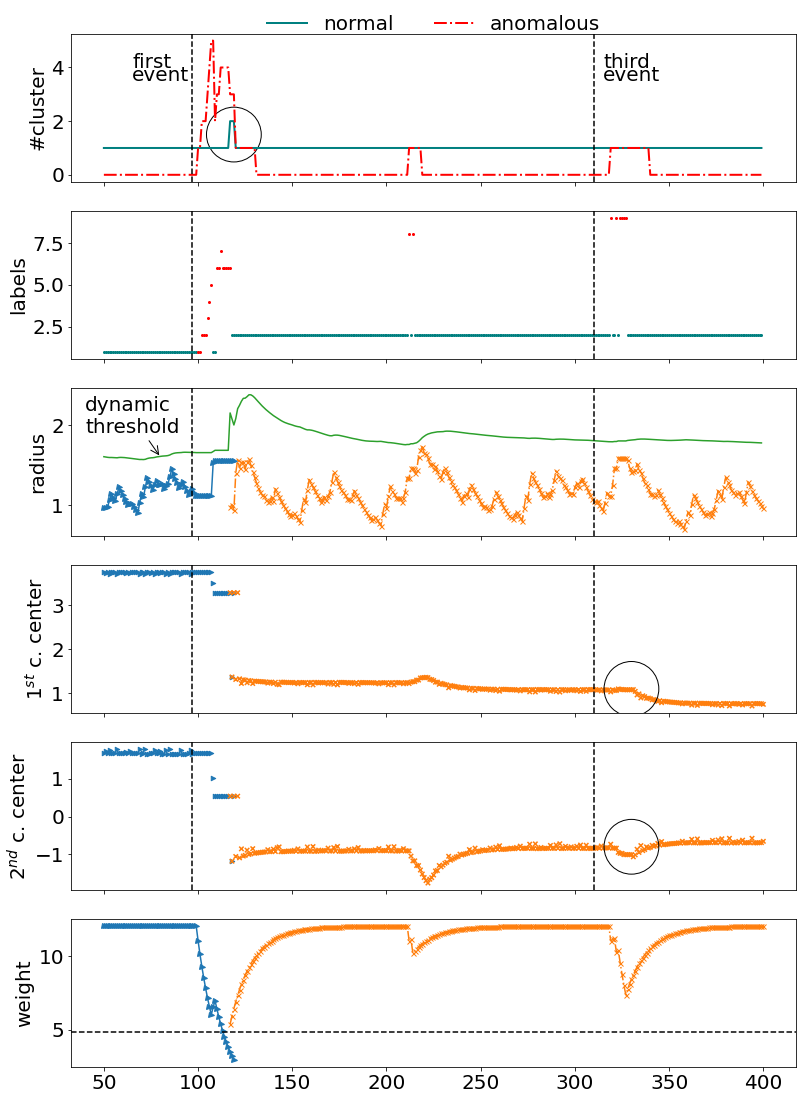

In [13]:
fig, ax = plt.subplots(subplots, sharex=True, figsize=(13,19))

plot_normal_vs_outlier_cluster_evolution(ax[0])
plot_assigned_labels(ax[1])
plot_radius(ax[2])
plot_first_center(ax[3])
plot_second_center(ax[4])
plot_vertical_event([ax[0], ax[1], ax[2], ax[3], ax[4]], [97, 310])

ax[0].text(65, 4, 'first', fontsize=text_size)
ax[0].text(65, 3.5, 'event', fontsize=text_size)

ax[0].text(315, 4, 'third', fontsize=text_size)
ax[0].text(315, 3.5, 'event', fontsize=text_size)
ax[0].scatter(119, 1.5, s=3000, facecolors='none', edgecolors='k')

ax[2].annotate('dynamic\nthreshold', xy=(80, 1.6), xytext=(40, 1.9),
            arrowprops=dict(arrowstyle="->"), fontsize=20
            )

ax[1].text(50, -2, '-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=False, fontsize=20, frameon=False)

ax[3].scatter(330, 1.1, s=3000, facecolors='none', edgecolors='k')
ax[4].scatter(330, -0.8, s=3000, facecolors='none', edgecolors='k')

arrow_args = dict(arrowstyle="->")

plot_weight(ax[5])